In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
ff_data = pd.read_csv("ff_data.csv")

In [3]:
ff_data.head()

,Player,Team,FantPos,Age,G,Cmp,PassAtt,PassYds,PassTD,Int,...,PosRank,OvRank,Year,adp,draft_pick,draft_year,Experience,Rookie,Soph,Third
0,DeMarcoMurray,Cowboys,RB,26,16,0.00,0.00,0.00,0.00,0.0,...,1,1.0,2014,14.2,71,2011,3,0,0,0
1,MarshawnLynch,Seahawks,RB,28,16,0.00,0.00,0.00,0.00,0.0,...,3,3.0,2014,15.9,12,2007,7,0,0,0
2,AntonioBrown,Steelers,WR,26,16,0.12,0.12,1.25,0.06,0.0,...,1,4.0,2014,18.4,195,2010,4,0,0,0
3,MattForte,Bears,RB,29,16,0.00,0.00,0.00,0.00,0.0,...,4,5.0,2014,4.2,44,2008,6,0,0,0
4,EddieLacy,Packers,RB,24,16,0.00,0.00,0.00,0.00,0.0,...,6,7.0,2014,6.2,61,2013,1,0,1,0


In [4]:
rookies = ff_data[ff_data["Rookie"]==1]
sophs = ff_data[ff_data["Soph"]==1]
thirds = ff_data[ff_data["Third"]==1]

In [5]:
from scipy.stats import ttest_ind

In [6]:
print(ttest_ind(rookies["PPR"], sophs["PPR"]).pvalue)
print(ttest_ind(rookies["PPR"], thirds["PPR"]).pvalue)
print(ttest_ind(sophs["PPR"], thirds["PPR"]).pvalue)

0.000892051328545278
3.6832257688679865e-06
0.19143539006646135


By using t-test to compare the sample means for rookies vs. sophomore and third year players, we can see that there is significance for us to fail to reject the alternative hypothesis regarding rookie performance vs. other years. However, there is not sufficient evidence for us to claim that there is a significant difference between sophomore and third year performance.

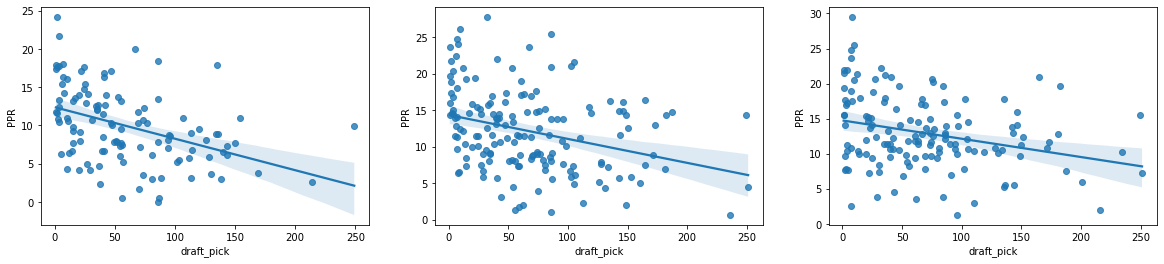

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
sns.regplot(x="draft_pick", y="PPR", data=rookies, ax=axs[0])
sns.regplot(x="draft_pick", y="PPR", data=sophs, ax=axs[1])
sns.regplot(x="draft_pick", y="PPR", data=thirds, ax=axs[2]);

In [8]:
import statsmodels.api as sm

orlm_X = rookies["draft_pick"]
orlm_X = sm.add_constant(orlm_X)

orlm = sm.OLS(rookies["PPR"], orlm_X)
orlm_results = orlm.fit()
print(orlm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     23.55
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           3.97e-06
Time:                        13:07:41   Log-Likelihood:                -331.63
No. Observations:                 114   AIC:                             667.3
Df Residuals:                     112   BIC:                             672.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3839      0.653     18.964      0.0

In [9]:
oslm_X = sophs["draft_pick"]
oslm_X = sm.add_constant(oslm_X)

oslm = sm.OLS(sophs["PPR"], oslm_X)
oslm_results = oslm.fit()
print(oslm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     17.52
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           4.69e-05
Time:                        13:07:41   Log-Likelihood:                -496.64
No. Observations:                 161   AIC:                             997.3
Df Residuals:                     159   BIC:                             1003.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.3341      0.671     21.356      0.0

In [10]:
otlm_X = thirds["draft_pick"]
otlm_X = sm.add_constant(otlm_X)

otlm = sm.OLS(thirds["PPR"], otlm_X)
otlm_results = otlm.fit()
print(otlm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     12.75
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           0.000488
Time:                        13:07:41   Log-Likelihood:                -430.73
No. Observations:                 143   AIC:                             865.5
Df Residuals:                     141   BIC:                             871.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.7446      0.651     22.653      0.0

As we can see, the R^2 value is already fairly low for rookies, but as it is higher than the R^2 values for sophomores and third years, it is reasonable to assume that draft capital is a better predictor for fantasy performance for rookies relative to other years. We can directly apply this by claiming that draft capital should not matter as much for second year players when predicting performance. For the next part, we will more directly examine rookie performance, as draft capital serves as a better predictor.

First, we'll create an 80/20 split for train vs. test using rookie data.

In [11]:
from sklearn.model_selection import train_test_split

rookie_train, rookie_test = train_test_split(rookies, test_size=0.2)

As we see that the residual plot is skewed right, we want to make a better fit, so we take the log transformation and build a new model.

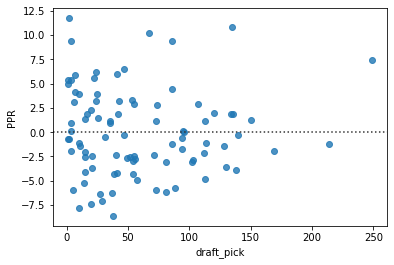

In [12]:
sns.residplot(x="draft_pick", y="PPR", data=rookie_train);

In [13]:
import statsmodels.api as sm

orlm_2_X = np.log(rookie_train["draft_pick"])
orlm_2_X = sm.add_constant(orlm_2_X)

orlm_2 = sm.OLS(rookie_train["PPR"], orlm_2_X)
orlm_2_results = orlm_2.fit()
print(orlm_2_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     28.84
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           6.22e-07
Time:                        13:07:42   Log-Likelihood:                -260.70
No. Observations:                  91   AIC:                             525.4
Df Residuals:                      89   BIC:                             530.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.7337      1.307     12.802      0.0

This improves the R^2 value, so we'll move forwards with it.

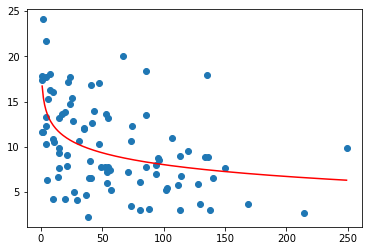

In [14]:
x=np.arange(1, 250)
y=(orlm_2_results.params[1] * (np.log(x))) + orlm_2_results.params[0]
plt.scatter(x=rookie_train["draft_pick"], y=rookie_train["PPR"])
plt.plot(x,y, color="red");

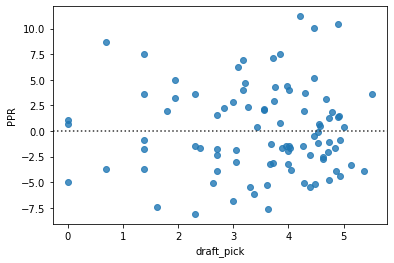

In [15]:
sns.residplot(x=np.log(rookie_train["draft_pick"]), y=rookie_train["PPR"]);

This clearly is a better fit. To further check fit, we need to do residual analysis for any outliers or cases with large influence on our final model. We will check studentized residuals as well as Cook's distance

In [16]:
orlm_2_resids = rookie_train["PPR"] - orlm_2_results.predict()
orlm_2_std_resids = (orlm_2_resids) / np.std(rookie_train["PPR"])
orlm_2_std_resids.sort_values()

127   -1.660179
720   -1.553300
557   -1.511645
276   -1.401385
278   -1.268503
         ...   
295    1.548452
579    1.776814
441    2.066996
320    2.134243
442    2.292195
Name: PPR, Length: 91, dtype: float64

This shows that there are no residual values greater than 3 or less than -3, proving there are no significant outliers.

In [17]:
from statsmodels.stats.outliers_influence import OLSInfluence

OLSInfluence(orlm_2_results).resid_studentized_internal.sort_values()

127   -1.908920
720   -1.777465
557   -1.750941
276   -1.604912
278   -1.451565
         ...   
295    1.799138
579    2.089386
441    2.372406
320    2.458455
442    2.627203
Length: 91, dtype: float64

This same sentiment is echoed with the studentized residuals, as no point has a studentized residual greater than 3 or less than -3.

In [18]:
OLSInfluence(orlm_2_results).cooks_distance[0].max()

0.14812609533338864

The maximum Cook's distance is far from the mark of .5 that indicates that a data point significantly changes the fit. Therefore, we can assume the current state of the data is free of threatening outliers. 

-------------

Since we are content with our current predictor, we want to better the model. This will involve adding a new feature, but to choose what feature to add, we need to use our domain knowledge. We do not have access to the players' college data nor combine data, but we can look at a few things relating to their position, the prior year production of the team they are drafted to.

First, we will use their position to create a categorical predictor. This is crucial, as any experience following the NFL tells us that it is very rare for a rookie QB to do well that is not drafted in the first round, but frequently late round receivers or running backs do well. To sort, we will dummy-encode, and leave no column for WRs/TEs so that we treat them as blanket pass catchers. There are so few tight ends it doesn't make sense to make them accounted for separate.

In [19]:
import warnings

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

rookie_train["RB"] = ((rookie_train.FantPos=="RB")*1).copy()
rookie_train["QB"] = ((rookie_train.FantPos=="QB")*1).copy()

In [20]:
rookie_train

,Player,Team,FantPos,Age,G,Cmp,PassAtt,PassYds,PassTD,Int,...,Year,adp,draft_pick,draft_year,Experience,Rookie,Soph,Third,RB,QB
506,JamaalWilliams,Packers,RB,22,16,0.00,0.00,0.00,0.00,0.00,...,2017,114.3,134,2017,0,1,0,0,1,0
859,DarwinThompson,Chiefs,RB,22,12,0.00,0.00,0.00,0.00,0.00,...,2019,86.0,214,2019,0,1,0,0,1,0
850,JusticeHill,Ravens,RB,22,16,0.00,0.00,0.00,0.00,0.00,...,2019,120.7,113,2019,0,1,0,0,1,0
579,SaquonBarkley,Giants,RB,21,16,0.00,0.00,0.00,0.00,0.00,...,2018,6.5,2,2018,0,1,0,0,1,0
281,DavidCobb,Titans,RB,22,7,0.00,0.00,0.00,0.00,0.00,...,2015,130.4,138,2015,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,KylerMurray,Cardinals,QB,22,16,21.81,33.88,232.62,1.25,0.75,...,2019,110.9,1,2019,0,1,0,0,0,1
236,AmeerAbdullah,Lions,RB,22,16,0.00,0.00,0.00,0.00,0.00,...,2015,41.5,54,2015,0,1,0,0,1,0
1067,KylePitts,Falcons,TE,21,17,0.00,0.00,0.00,0.00,0.00,...,2021,40.3,4,2021,0,1,0,0,0,0
1092,DeVontaSmith,Eagles,WR,23,17,0.00,0.00,0.00,0.00,0.00,...,2021,77.6,10,2021,0,1,0,0,0,0


In [21]:
orlm_3_X = pd.DataFrame({"pick": np.log(rookie_train["draft_pick"]), 
                         "RB": rookie_train["RB"], "QB": rookie_train["QB"], 
                         "RB_interact": rookie_train["RB"]*(np.log(rookie_train["draft_pick"])), 
                         "QB_interact": rookie_train["QB"]*(np.log(rookie_train["draft_pick"]))})
orlm_3_X = sm.add_constant(orlm_3_X)

orlm_3 = sm.OLS(rookie_train["PPR"], orlm_3_X)
orlm_3_results = orlm_3.fit()
print(orlm_3_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     10.70
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           5.36e-08
Time:                        13:07:45   Log-Likelihood:                -251.26
No. Observations:                  91   AIC:                             514.5
Df Residuals:                      85   BIC:                             529.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          14.1260      2.358      5.990      

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

for idx in np.arange(len(orlm_3_X.columns.tolist())):
    print(f"VIF of {orlm_3_X.columns.tolist()[idx]}: {variance_inflation_factor(orlm_3_X, idx)}")

VIF of const: 32.27765027555346
VIF of pick: 4.99052048977178
VIF of RB: 16.266143868339906
VIF of QB: 4.352462482808403
VIF of RB_interact: 22.87346600257501
VIF of QB_interact: 3.170604350931195


We now see that there is a strong amount of multicorrelation, evidenced by the enormous VIF values for RBs. Still, this value means that the already low p-values are spiked by close to 20 times. For QBs the resulting VIF still does not indicate significance, so we have reason to believe we should drop at least the "QB" feature.

In [23]:
orlm_4_X = pd.DataFrame({"pick": np.log(rookie_train["draft_pick"]), 
                         "RB": rookie_train["RB"],
                         "RB_interact": rookie_train["RB"]*(np.log(rookie_train["draft_pick"])), 
                         "QB_interact": rookie_train["QB"]*(np.log(rookie_train["draft_pick"]))})
orlm_4_X = sm.add_constant(orlm_4_X)

orlm_4 = sm.OLS(rookie_train["PPR"], orlm_4_X)
orlm_4_results = orlm_4.fit()
print(orlm_4_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     13.53
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           1.35e-08
Time:                        13:07:45   Log-Likelihood:                -251.26
No. Observations:                  91   AIC:                             512.5
Df Residuals:                      86   BIC:                             525.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          14.2970      1.493      9.577      

In [24]:
for idx in np.arange(len(orlm_4_X.columns.tolist())):
    print(f"VIF of {orlm_4_X.columns.tolist()[idx]}: {variance_inflation_factor(orlm_4_X, idx)}")

VIF of const: 13.084154478072982
VIF of pick: 2.2690406550759556
VIF of RB: 11.496162664232328
VIF of RB_interact: 15.189481904055857
VIF of QB_interact: 1.0677143433907221


Now, as there are no p-values greater than .05, we decide to stick with this model in it's current form to move forward with prediction. Let's now plot the curves for the new model.

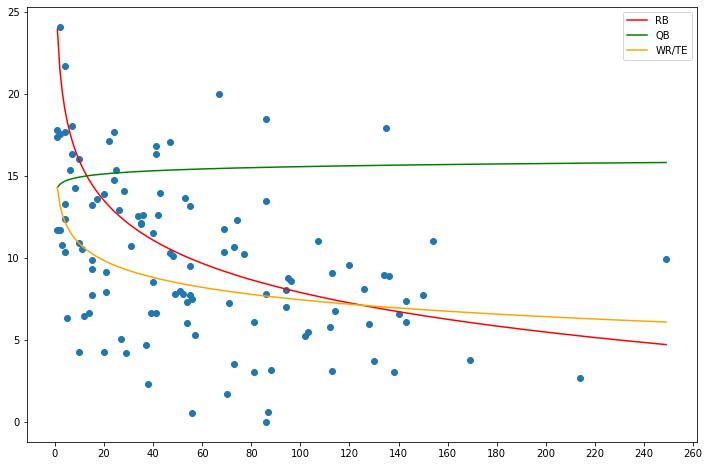

In [25]:
plt.figure(figsize=(12, 8))

x=np.arange(1, 250)
y1 = (orlm_4_results.params[0]) + (orlm_4_results.params[1] * np.log(x)) + \
     (orlm_4_results.params[2] * 1) + (orlm_4_results.params[3] * np.log(x))
y2 = (orlm_4_results.params[0]) + (orlm_4_results.params[1] * np.log(x)) + \
     (orlm_4_results.params[4] * np.log(x))
y3 = (orlm_4_results.params[0]) + (orlm_4_results.params[1] * np.log(x))

plt.scatter(x=rookies["draft_pick"], y=rookies["PPR"])
plt.plot(x,y1, color="red", label="RB")
plt.plot(x,y2, color="green", label="QB")
plt.plot(x,y3, color="orange", label="WR/TE")
plt.legend()
plt.xticks(np.arange(0, 280, 20));

We can see here that being drafted in the first or second round makes a huge difference for RBs, a fairly large difference for WRs, and a minimal difference for QBs. However, this is not to say that QBs drafted later are better, but rather to say that there aren't QBs drafted later that have an impact to be included in fantasy data. 

-----------

Everyone is excited about a rookie that steps into a good offense, but how much does that offense's success lend itself to predicting how highly we should draft that rookie?

To do this, we'll have to load in data on each team's success, so that we can eventually add it on to the information about the player.

In [26]:
team_data = pd.read_csv("season_data/team_data.csv")
team_data.head()

,Team,PassYPG,RunYPG,TotalYPG,PPG,Year
0,Broncos,340.2,117.1,457.3,37.9,2013
1,Eagles,256.9,160.4,417.2,27.6,2013
2,Packers,266.8,133.5,400.2,26.1,2013
3,Saints,307.4,92.1,399.4,25.9,2013
4,Chargers,270.5,122.8,393.3,24.8,2013


In [27]:
rookie_train["prior_year"] = rookie_train["Year"] - 1
rookie_train = rookie_train.merge(team_data, how="inner", left_on=["Team", "prior_year"], right_on=["Team", "Year"])

In [28]:
rookie_train

,Player,Team,FantPos,Age,G,Cmp,PassAtt,PassYds,PassTD,Int,...,Soph,Third,RB,QB,prior_year,PassYPG,RunYPG,TotalYPG,PPG,Year_y
0,JamaalWilliams,Packers,RB,22,16,0.00,0.00,0.00,0.00,0.00,...,0,0,1,0,2016,262.4,106.3,368.8,27.0,2016
1,DarwinThompson,Chiefs,RB,22,12,0.00,0.00,0.00,0.00,0.00,...,0,0,1,0,2018,309.7,115.9,425.6,35.3,2018
2,MecoleHardman,Chiefs,WR,21,16,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,2018,309.7,115.9,425.6,35.3,2018
3,JusticeHill,Ravens,RB,22,16,0.00,0.00,0.00,0.00,0.00,...,0,0,1,0,2018,222.4,152.6,374.9,24.3,2018
4,SaquonBarkley,Giants,RB,21,16,0.00,0.00,0.00,0.00,0.00,...,0,0,1,0,2017,217.4,96.8,314.2,15.4,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,KerryonJohnson,Lions,RB,21,10,0.00,0.00,0.00,0.00,0.00,...,0,0,1,0,2017,261.4,76.3,337.8,25.6,2017
87,RonaldJonesII,Buccaneers,RB,21,9,0.00,0.00,0.00,0.00,0.00,...,0,0,1,0,2017,272.9,90.6,363.5,20.9,2017
88,KylerMurray,Cardinals,QB,22,16,21.81,33.88,232.62,1.25,0.75,...,0,0,0,1,2018,157.7,83.9,241.6,14.1,2018
89,AmeerAbdullah,Lions,RB,22,16,0.00,0.00,0.00,0.00,0.00,...,0,0,1,0,2014,251.9,88.9,340.8,20.1,2014


Now that we've loaded in the previous season's team data, we will see if it can help us predict the player's performance better. First, we will add the team's points per game, as it would make sense that a team that scores more would produce more scoring opportunities for its rookies.

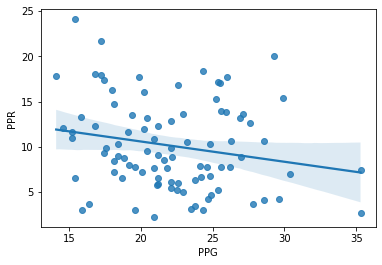

In [29]:
sns.regplot(x="PPG", y="PPR", data=rookie_train);

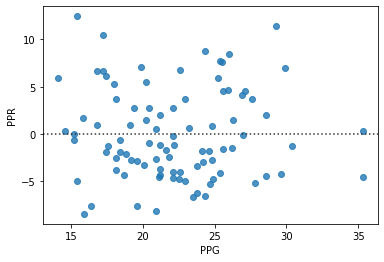

In [30]:
sns.residplot(x=rookie_train["PPG"], y=rookie_train["PPR"]);

The initial plot of points per game indicates a relatively linear trend, and the residual plot proves this. 

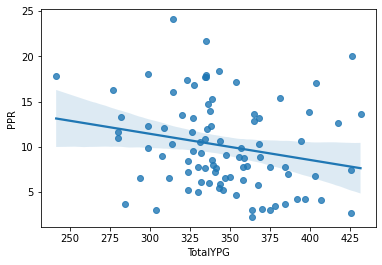

In [31]:
sns.regplot(x="TotalYPG", y="PPR", data=rookie_train);

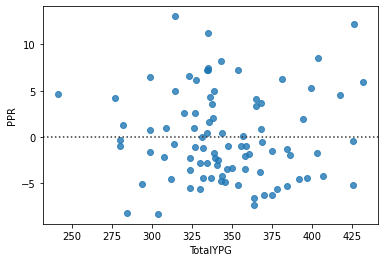

In [32]:
sns.residplot(x=rookie_train["TotalYPG"], y=rookie_train["PPR"]);

When we examine these points, we also see a linear trend with evenly distributed residuals. Therefore, we can implement these two features into the next model. However, the trends here indicate that as an offense gets better, the player scores less PPR points per game. This bucks the notion of a young player stepping into a good offense and rather indicates that bad teams have more opportunity for production.

In [33]:
orlm_5_X = pd.DataFrame({"pick": np.log(rookie_train["draft_pick"]), 
                         "RB": rookie_train["RB"],
                         "RB_interact": rookie_train["RB"]*(np.log(rookie_train["draft_pick"])), 
                         "QB_interact": rookie_train["QB"]*(np.log(rookie_train["draft_pick"])),
                         "PPG": rookie_train["PPG"], "TotalYds": rookie_train["TotalYPG"]})
orlm_5_X = sm.add_constant(orlm_5_X)

orlm_5 = sm.OLS(rookie_train["PPR"], orlm_5_X)
orlm_5_results = orlm_5.fit()
print(orlm_5_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     8.921
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           1.57e-07
Time:                        13:07:49   Log-Likelihood:                -251.04
No. Observations:                  91   AIC:                             516.1
Df Residuals:                      84   BIC:                             533.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          17.0365      4.633      3.677      

The p-value is hugely above .05 when we add both terms, so let's check colinearity. The VIF indicates that PPG is still lacks significance, but on the other hand, total yards per game is reasonable, so then we will remove points per game and move on.

In [34]:
for idx in np.arange(len(orlm_5_X.columns.tolist())):
    print(f"VIF of {orlm_5_X.columns.tolist()[idx]}: {variance_inflation_factor(orlm_5_X, idx)}")

VIF of const: 123.70392764752911
VIF of pick: 2.55493019890787
VIF of RB: 11.746178138292162
VIF of RB_interact: 15.686748487989329
VIF of QB_interact: 1.1114506592975408
VIF of PPG: 3.5981655588271666
VIF of TotalYds: 3.690504500129302


In [35]:
orlm_6_X = pd.DataFrame({"pick": np.log(rookie_train["draft_pick"]), 
                         "RB": rookie_train["RB"],
                         "RB_interact": rookie_train["RB"]*(np.log(rookie_train["draft_pick"])), 
                         "QB_interact": rookie_train["QB"]*(np.log(rookie_train["draft_pick"])),
                         "TotalYds": rookie_train["TotalYPG"]})
orlm_6_X = sm.add_constant(orlm_6_X)

orlm_6 = sm.OLS(rookie_train["PPR"], orlm_6_X)
orlm_6_results = orlm_6.fit()
print(orlm_6_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     10.77
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           4.83e-08
Time:                        13:07:49   Log-Likelihood:                -251.14
No. Observations:                  91   AIC:                             514.3
Df Residuals:                      85   BIC:                             529.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          16.1126      4.064      3.965      

After this modification, there are no terms that stick out. Because of this, we are satisfied with our model.

In [36]:
rookie_train.head()

,Player,Team,FantPos,Age,G,Cmp,PassAtt,PassYds,PassTD,Int,...,Soph,Third,RB,QB,prior_year,PassYPG,RunYPG,TotalYPG,PPG,Year_y
0,JamaalWilliams,Packers,RB,22,16,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,2016,262.4,106.3,368.8,27.0,2016
1,DarwinThompson,Chiefs,RB,22,12,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,2018,309.7,115.9,425.6,35.3,2018
2,MecoleHardman,Chiefs,WR,21,16,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,2018,309.7,115.9,425.6,35.3,2018
3,JusticeHill,Ravens,RB,22,16,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,2018,222.4,152.6,374.9,24.3,2018
4,SaquonBarkley,Giants,RB,21,16,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,2017,217.4,96.8,314.2,15.4,2017


In [37]:
ff_data.head()

,Player,Team,FantPos,Age,G,Cmp,PassAtt,PassYds,PassTD,Int,...,PosRank,OvRank,Year,adp,draft_pick,draft_year,Experience,Rookie,Soph,Third
0,DeMarcoMurray,Cowboys,RB,26,16,0.00,0.00,0.00,0.00,0.0,...,1,1.0,2014,14.2,71,2011,3,0,0,0
1,MarshawnLynch,Seahawks,RB,28,16,0.00,0.00,0.00,0.00,0.0,...,3,3.0,2014,15.9,12,2007,7,0,0,0
2,AntonioBrown,Steelers,WR,26,16,0.12,0.12,1.25,0.06,0.0,...,1,4.0,2014,18.4,195,2010,4,0,0,0
3,MattForte,Bears,RB,29,16,0.00,0.00,0.00,0.00,0.0,...,4,5.0,2014,4.2,44,2008,6,0,0,0
4,EddieLacy,Packers,RB,24,16,0.00,0.00,0.00,0.00,0.0,...,6,7.0,2014,6.2,61,2013,1,0,1,0


In [38]:
ff_pna = pd.read_csv("season_data/ff_points.csv")
ff_pna.head()

,Player,Team,FantPos,Age,G,Cmp,PassAtt,PassYds,PassTD,Int,...,RushYds,RushTD,Tgt,Rec,RecYds,RecTD,PPR,PosRank,OvRank,Year
0,JamaalCharles,Chiefs,RB,27,15,0.00,0.00,0.00,0.00,0.00,...,85.80,0.80,6.93,4.67,46.20,0.47,25.20,1,1.0,2013
1,LeSeanMcCoy,Eagles,RB,25,16,0.00,0.00,0.00,0.00,0.00,...,100.44,0.56,4.00,3.25,33.69,0.12,20.66,2,2.0,2013
2,PeytonManning,Broncos,QB,37,16,28.12,41.19,342.31,3.44,0.62,...,-1.94,0.06,0.00,0.00,0.00,0.00,25.62,1,3.0,2013
3,MattForte,Bears,RB,28,16,0.00,0.00,0.00,0.00,0.00,...,83.69,0.56,5.94,4.62,37.12,0.19,21.08,3,4.0,2013
4,JimmyGraham,Saints,TE,27,16,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,8.88,5.38,75.94,1.00,18.97,1,5.0,2013


In [39]:
pd.set_option('display.max_columns', 500)
pg_columns = ff_pna.columns.tolist()[5:18]
for column in pg_columns:
    ff_pna[column] = np.round(((pd.to_numeric(ff_pna[column], errors='coerce')) * ff_pna["G"]), 2)

In [40]:
ff_pna = ff_pna.groupby(["Year", "Team"], as_index=False).agg(sum)
ff_pna_pre_17 = ff_pna[ff_pna["Year"] <= 2020]
ff_pna_post_17 = ff_pna[ff_pna["Year"] >= 2021]
pna_columns = ff_pna.columns.tolist()[4:17]
for column in pna_columns:
    ff_pna_pre_17[column] = np.round((ff_pna_pre_17[column] / 16), 1)
    ff_pna_post_17[column] = np.round((ff_pna_post_17[column] / 17), 1)
ff_pna = pd.concat([ff_pna_pre_17, ff_pna_post_17], ignore_index=True)
ff_pna

,Year,Team,Age,G,Cmp,PassAtt,PassYds,PassTD,Int,RushAtt,RushYds,RushTD,Tgt,Rec,RecYds,RecTD,PPR,PosRank,OvRank
0,2013,2TM,716,257,3.9,9.3,47.6,0.1,0.2,27.4,94.1,0.5,18.0,10.1,92.3,0.5,36.7,3629,0.0
1,2013,3TM,28,9,7.8,12.5,87.0,0.5,0.3,1.2,4.1,0.0,0.0,0.0,0.0,0.0,4.5,41,0.0
2,2013,49ers,450,193,15.3,26.1,200.6,1.3,0.5,31.4,135.6,1.1,23.8,14.4,192.3,1.3,73.7,1461,156.0
3,2013,Bears,378,188,23.3,36.2,278.1,2.0,0.8,25.2,114.2,0.8,35.5,23.2,278.2,2.0,97.0,1182,100.0
4,2013,Bengals,457,227,22.8,36.7,269.9,2.1,1.2,30.0,109.7,0.9,36.1,22.8,269.9,2.1,93.6,1542,149.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,2021,Steelers,487,220,25.0,39.0,236.3,1.4,0.6,24.2,93.1,0.6,38.4,24.9,236.2,1.4,82.5,1919,44.0
300,2021,Texans,492,178,20.8,32.1,213.5,1.2,0.9,14.2,52.9,0.4,27.9,19.1,196.6,1.1,64.3,1686,56.0
301,2021,Titans,629,217,21.1,31.4,219.9,1.3,0.8,30.7,136.3,1.3,29.6,20.3,214.2,1.3,82.6,2271,199.0
302,2021,Vikings,493,208,23.4,35.5,261.8,2.0,0.4,26.0,111.8,0.6,33.7,23.2,259.5,2.0,93.6,1623,164.0


In [41]:
ff_pna = ff_pna[["Year", "Team", "Cmp", "PassAtt", "PassYds", "PassTD", "Int", 
                 "RushAtt", "RushYds", "RushTD", "Tgt", "Rec", "RecYds", "RecTD"]]
ff_pna = ff_pna[(ff_pna["Team"]!="2TM")]
ff_pna = ff_pna[(ff_pna["Team"]!="3TM")]
ff_pna = ff_pna[(ff_pna["Team"]!="4TM")]

In [42]:
ff_pna

,Year,Team,Cmp,PassAtt,PassYds,PassTD,Int,RushAtt,RushYds,RushTD,Tgt,Rec,RecYds,RecTD
2,2013,49ers,15.3,26.1,200.6,1.3,0.5,31.4,135.6,1.1,23.8,14.4,192.3,1.3
3,2013,Bears,23.3,36.2,278.1,2.0,0.8,25.2,114.2,0.8,35.5,23.2,278.2,2.0
4,2013,Bengals,22.8,36.7,269.9,2.1,1.2,30.0,109.7,0.9,36.1,22.8,269.9,2.1
5,2013,Bills,18.7,32.6,210.8,1.0,0.9,31.9,136.3,0.9,31.9,18.4,210.2,1.0
6,2013,Broncos,28.8,42.2,348.2,3.4,0.6,28.7,114.9,1.0,41.9,28.8,348.3,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,2021,Steelers,25.0,39.0,236.3,1.4,0.6,24.2,93.1,0.6,38.4,24.9,236.2,1.4
300,2021,Texans,20.8,32.1,213.5,1.2,0.9,14.2,52.9,0.4,27.9,19.1,196.6,1.1
301,2021,Titans,21.1,31.4,219.9,1.3,0.8,30.7,136.3,1.3,29.6,20.3,214.2,1.3
302,2021,Vikings,23.4,35.5,261.8,2.0,0.4,26.0,111.8,0.6,33.7,23.2,259.5,2.0


In [43]:
players = pd.read_csv("season_data/ff_points.csv")
players.head()

,Player,Team,FantPos,Age,G,Cmp,PassAtt,PassYds,PassTD,Int,RushAtt,RushYds,RushTD,Tgt,Rec,RecYds,RecTD,PPR,PosRank,OvRank,Year
0,JamaalCharles,Chiefs,RB,27,15,0.00,0.00,0.00,0.00,0.00,17.27,85.80,0.80,6.93,4.67,46.20,0.47,25.20,1,1.0,2013
1,LeSeanMcCoy,Eagles,RB,25,16,0.00,0.00,0.00,0.00,0.00,19.62,100.44,0.56,4.00,3.25,33.69,0.12,20.66,2,2.0,2013
2,PeytonManning,Broncos,QB,37,16,28.12,41.19,342.31,3.44,0.62,2.00,-1.94,0.06,0.00,0.00,0.00,0.00,25.62,1,3.0,2013
3,MattForte,Bears,RB,28,16,0.00,0.00,0.00,0.00,0.00,18.06,83.69,0.56,5.94,4.62,37.12,0.19,21.08,3,4.0,2013
4,JimmyGraham,Saints,TE,27,16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.88,5.38,75.94,1.00,18.97,1,5.0,2013


In [44]:
players[(players["Player"]=="JamaalCharles") & (players["Year"]==2013)]

,Player,Team,FantPos,Age,G,Cmp,PassAtt,PassYds,PassTD,Int,RushAtt,RushYds,RushTD,Tgt,Rec,RecYds,RecTD,PPR,PosRank,OvRank,Year
0,JamaalCharles,Chiefs,RB,27,15,0.0,0.0,0.0,0.0,0.0,17.27,85.8,0.8,6.93,4.67,46.2,0.47,25.2,1,1.0,2013


In [45]:
years = np.arange(2013, 2021)
lost_players = pd.DataFrame()

for year in years:
    for player in players["Player"].unique():
        player_year = players[(players["Player"]==player) & (players["Year"]==year)]
        next_player_year = players[(players["Player"]==player) & (players["Year"]==year+1)]
        if (len(player_year) == 1) & (len(next_player_year)==1):
            if player_year["Team"].iloc[0] == next_player_year["Team"].iloc[0]:
                pass
            else:
                lost_players = pd.concat([lost_players, player_year])
        elif (len(player_year) == 1) & (len(next_player_year)==0):
            lost_players = pd.concat([lost_players, player_year])
        else:
            pass

In [46]:
lost_columns = lost_players.columns.tolist()[5:18]
for column in lost_columns:
    lost_players[column] = np.round(((pd.to_numeric(lost_players[column], errors='coerce')) * lost_players["G"]), 2)

In [47]:
lost_players.groupby(["Year", "Team"], as_index=False).agg(sum) 

,Year,Team,Age,G,Cmp,PassAtt,PassYds,PassTD,Int,RushAtt,RushYds,RushTD,Tgt,Rec,RecYds,RecTD,PPR,PosRank,OvRank
0,2013,2TM,716,257,63.00,149.01,761.00,2.00,4.00,438.93,1504.92,7.99,287.87,161.98,1477.02,7.93,586.68,3629,0.0
1,2013,3TM,28,9,124.02,199.98,1392.03,8.01,5.04,19.98,64.98,0.00,0.00,0.00,0.00,0.00,72.18,41,0.0
2,2013,49ers,153,59,1.00,1.00,13.00,0.00,0.00,124.08,467.08,4.96,42.05,18.97,172.06,0.00,117.55,654,0.0
3,2013,Bears,165,72,148.96,224.00,1828.96,12.96,0.96,75.96,265.91,3.96,53.94,36.96,299.00,5.10,272.69,727,0.0
4,2013,Bengals,151,59,0.00,0.00,0.00,0.00,0.00,237.00,844.00,7.04,107.95,68.08,941.18,9.92,344.54,540,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,2020,Steelers,154,45,4.00,5.00,2.00,0.00,0.00,179.96,768.98,5.98,77.05,58.91,360.06,0.00,207.98,697,0.0
266,2020,Texans,394,134,383.08,546.00,4843.04,32.96,7.04,193.87,761.94,4.03,291.92,215.94,2783.01,22.06,1024.12,1536,75.0
267,2020,Titans,132,58,0.00,0.00,0.00,0.00,0.00,5.03,10.08,1.05,206.93,137.94,1847.15,15.02,417.81,441,141.0
268,2020,Vikings,204,92,0.00,0.00,0.00,0.00,0.00,19.04,100.96,0.96,142.87,102.01,1156.84,9.78,293.90,888,0.0


In [48]:
lost_team_stats = lost_players.groupby(["Year", "Team"], as_index=False).agg(sum)
lost_team_stats = lost_team_stats[["Year", "Team", "Cmp", "PassAtt", "PassYds", "PassTD", "Int", 
                                   "RushAtt", "RushYds", "RushTD", "Tgt", "Rec", "RecYds", "RecTD"]]
lost_team_stats = lost_team_stats[(lost_team_stats["Team"]!="2TM")]
lost_team_stats = lost_team_stats[(lost_team_stats["Team"]!="3TM")]
lost_team_stats = lost_team_stats[(lost_team_stats["Team"]!="4TM")]

In [49]:
lost_team_stats["current_year"] = lost_team_stats.Year + 1

In [50]:
lost_team_stats = lost_team_stats.rename({"Cmp": "AvblCmp", "PassAtt": "AvblPassAtt", "PassYds": "AvblPassYds",
                                          "PassTD": "AvblPassTD", "Int": "AvblInt", "RushAtt": "AvblRushAtt",
                                          "RushYds": "AvblRushYds", "RushTD": "AvblRushTD", "Tgt": "AvblTgt",
                                          "Rec": "AvblRec", "RecYds": "AvblRecYds", "RecTD": "AvblRecTD"},
                                         axis=1)
lost_team_stats = lost_team_stats[["Team", "current_year", "AvblCmp", "AvblPassAtt", "AvblPassYds", 
                                   "AvblPassTD", "AvblRushAtt", "AvblRushYds", "AvblRushTD", 
                                   "AvblTgt", "AvblRec", "AvblRecYds", "AvblRecTD"]]

In [51]:
lost_team_stats

,Team,current_year,AvblCmp,AvblPassAtt,AvblPassYds,AvblPassTD,AvblRushAtt,AvblRushYds,AvblRushTD,AvblTgt,AvblRec,AvblRecYds,AvblRecTD
2,49ers,2014,1.00,1.00,13.00,0.00,124.08,467.08,4.96,42.05,18.97,172.06,0.00
3,Bears,2014,148.96,224.00,1828.96,12.96,75.96,265.91,3.96,53.94,36.96,299.00,5.10
4,Bengals,2014,0.00,0.00,0.00,0.00,237.00,844.00,7.04,107.95,68.08,941.18,9.92
5,Bills,2014,119.00,216.02,1401.00,5.02,32.96,97.06,1.02,165.90,77.92,972.92,4.92
6,Broncos,2014,0.00,0.00,0.00,0.00,242.01,1045.13,9.92,218.89,154.06,1883.06,15.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,Steelers,2021,4.00,5.00,2.00,0.00,179.96,768.98,5.98,77.05,58.91,360.06,0.00
266,Texans,2021,383.08,546.00,4843.04,32.96,193.87,761.94,4.03,291.92,215.94,2783.01,22.06
267,Titans,2021,0.00,0.00,0.00,0.00,5.03,10.08,1.05,206.93,137.94,1847.15,15.02
268,Vikings,2021,0.00,0.00,0.00,0.00,19.04,100.96,0.96,142.87,102.01,1156.84,9.78


In [52]:
rookie_train = rookie_train.merge(lost_team_stats, how="inner", 
                                  left_on=["Team", "Year_x"], right_on=["Team", "current_year"])
rookie_train.head()

,Player,Team,FantPos,Age,G,Cmp,PassAtt,PassYds,PassTD,Int,RushAtt,RushYds,RushTD,Tgt,Rec,RecYds,RecTD,PPR,PosRank,OvRank,Year_x,adp,draft_pick,draft_year,Experience,Rookie,Soph,Third,RB,QB,prior_year,PassYPG,RunYPG,TotalYPG,PPG,Year_y,current_year,AvblCmp,AvblPassAtt,AvblPassYds,AvblPassTD,AvblRushAtt,AvblRushYds,AvblRushTD,AvblTgt,AvblRec,AvblRecYds,AvblRecTD
0,JamaalWilliams,Packers,RB,22,16,0.0,0.0,0.0,0.0,0.0,9.56,34.75,0.25,2.12,1.56,16.38,0.12,8.93,29,NaN,2017,114.3,134,2017,0,1,0,0,1,0,2016,262.4,106.3,368.8,27.0,2016,2017,0.00,0.00,0.00,0.00,143.99,537.00,0.00,91.05,57.95,582.02,2.98
1,DarwinThompson,Chiefs,RB,22,12,0.0,0.0,0.0,0.0,0.0,3.08,10.67,0.08,0.83,0.75,3.58,0.00,2.68,89,NaN,2019,86.0,214,2019,0,1,0,0,1,0,2018,309.7,115.9,425.6,35.3,2018,2019,2.00,3.00,29.00,0.00,184.96,832.02,7.04,121.95,75.93,949.02,16.99
2,MecoleHardman,Chiefs,WR,21,16,0.0,0.0,0.0,0.0,0.0,0.25,1.06,0.00,2.56,1.62,33.62,0.38,7.47,49,NaN,2019,137.7,56,2019,0,1,0,0,0,0,2018,309.7,115.9,425.6,35.3,2018,2019,2.00,3.00,29.00,0.00,184.96,832.02,7.04,121.95,75.93,949.02,16.99
3,JusticeHill,Ravens,RB,22,16,0.0,0.0,0.0,0.0,0.0,3.62,14.06,0.12,0.94,0.50,4.38,0.00,3.09,71,NaN,2019,120.7,113,2019,0,1,0,0,1,0,2018,222.4,152.6,374.9,24.3,2018,2019,232.02,378.99,2465.01,11.97,241.04,915.10,11.92,287.98,170.98,1848.09,12.00
4,SaquonBarkley,Giants,RB,21,16,0.0,0.0,0.0,0.0,0.0,16.31,81.69,0.69,7.56,5.69,45.06,0.25,24.11,2,2.0,2018,6.5,2,2018,0,1,0,0,1,0,2017,217.4,96.8,314.2,15.4,2017,2018,21.00,36.96,212.00,1.00,262.99,1020.07,4.95,273.02,161.06,1430.85,4.99


In [53]:
rookie_train = rookie_train.drop(["PosRank", "OvRank", "Year_x", "Year_y"], axis=1)

In [54]:
rookie_train.head()

,Player,Team,FantPos,Age,G,Cmp,PassAtt,PassYds,PassTD,Int,RushAtt,RushYds,RushTD,Tgt,Rec,RecYds,RecTD,PPR,adp,draft_pick,draft_year,Experience,Rookie,Soph,Third,RB,QB,prior_year,PassYPG,RunYPG,TotalYPG,PPG,current_year,AvblCmp,AvblPassAtt,AvblPassYds,AvblPassTD,AvblRushAtt,AvblRushYds,AvblRushTD,AvblTgt,AvblRec,AvblRecYds,AvblRecTD
0,JamaalWilliams,Packers,RB,22,16,0.0,0.0,0.0,0.0,0.0,9.56,34.75,0.25,2.12,1.56,16.38,0.12,8.93,114.3,134,2017,0,1,0,0,1,0,2016,262.4,106.3,368.8,27.0,2017,0.00,0.00,0.00,0.00,143.99,537.00,0.00,91.05,57.95,582.02,2.98
1,DarwinThompson,Chiefs,RB,22,12,0.0,0.0,0.0,0.0,0.0,3.08,10.67,0.08,0.83,0.75,3.58,0.00,2.68,86.0,214,2019,0,1,0,0,1,0,2018,309.7,115.9,425.6,35.3,2019,2.00,3.00,29.00,0.00,184.96,832.02,7.04,121.95,75.93,949.02,16.99
2,MecoleHardman,Chiefs,WR,21,16,0.0,0.0,0.0,0.0,0.0,0.25,1.06,0.00,2.56,1.62,33.62,0.38,7.47,137.7,56,2019,0,1,0,0,0,0,2018,309.7,115.9,425.6,35.3,2019,2.00,3.00,29.00,0.00,184.96,832.02,7.04,121.95,75.93,949.02,16.99
3,JusticeHill,Ravens,RB,22,16,0.0,0.0,0.0,0.0,0.0,3.62,14.06,0.12,0.94,0.50,4.38,0.00,3.09,120.7,113,2019,0,1,0,0,1,0,2018,222.4,152.6,374.9,24.3,2019,232.02,378.99,2465.01,11.97,241.04,915.10,11.92,287.98,170.98,1848.09,12.00
4,SaquonBarkley,Giants,RB,21,16,0.0,0.0,0.0,0.0,0.0,16.31,81.69,0.69,7.56,5.69,45.06,0.25,24.11,6.5,2,2018,0,1,0,0,1,0,2017,217.4,96.8,314.2,15.4,2018,21.00,36.96,212.00,1.00,262.99,1020.07,4.95,273.02,161.06,1430.85,4.99


Now that we've created a way to measure how much opportunity is available on a given rookie's team, let's check if we can add it to the model.

First, we will look at some scatter plots and residual plots to identify linear trends.

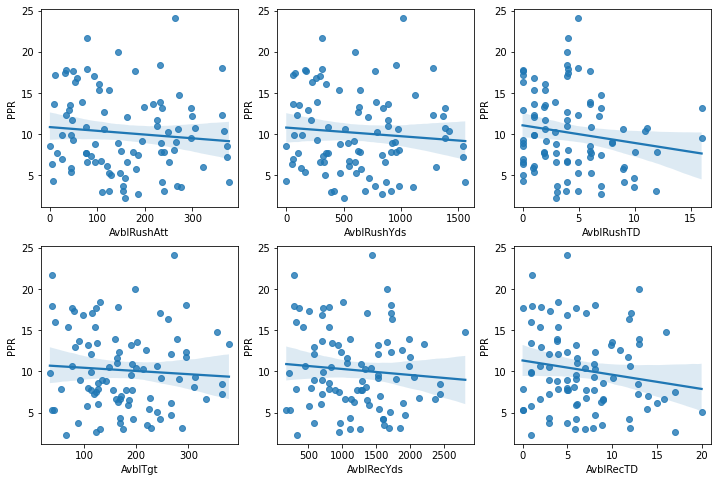

In [55]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
sns.regplot(x=(rookie_train["AvblRushAtt"]), y=rookie_train["PPR"], ax=axs[0, 0])
sns.regplot(x=(rookie_train["AvblRushYds"]), y=rookie_train["PPR"], ax=axs[0, 1])
sns.regplot(x=(rookie_train["AvblRushTD"]), y=rookie_train["PPR"], ax=axs[0, 2])
sns.regplot(x=(rookie_train["AvblTgt"]), y=rookie_train["PPR"], ax=axs[1, 0])
sns.regplot(x=(rookie_train["AvblRecYds"]), y=rookie_train["PPR"], ax=axs[1, 1])
sns.regplot(x=(rookie_train["AvblRecTD"]), y=rookie_train["PPR"], ax=axs[1, 2]);

There is some negative correlation regarding touchdowns, but generally, there is next to no pattern in these associations. This is not what we expected but also makes sense. Teams often sign free agents to replace production and don't always rely on new draft picks. However, I have a suspicion that higher draft picks benefit from opportunity more often, so we will plot these with interaction terms between the opportunity and the draft pick and see where it stands.

Taking the log of the draft picks once more and comparing the interaction with opportunity works quite well, so we'll stick with that as we move on.

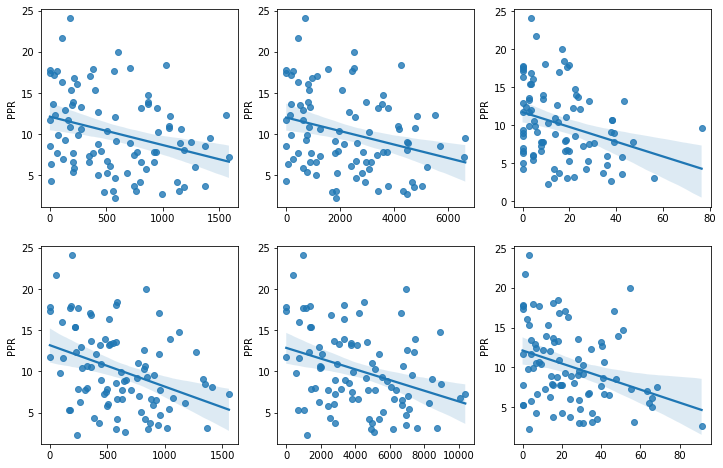

In [56]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
sns.regplot(x=(rookie_train["AvblRushAtt"]*np.log(rookie_train["draft_pick"])), 
            y=rookie_train["PPR"], ax=axs[0, 0])
sns.regplot(x=(rookie_train["AvblRushYds"]*np.log(rookie_train["draft_pick"])), 
            y=rookie_train["PPR"], ax=axs[0, 1])
sns.regplot(x=(rookie_train["AvblRushTD"]*np.log(rookie_train["draft_pick"])),
            y=rookie_train["PPR"], ax=axs[0, 2])
sns.regplot(x=(rookie_train["AvblTgt"]*np.log(rookie_train["draft_pick"])),
            y=rookie_train["PPR"], ax=axs[1, 0])
sns.regplot(x=(rookie_train["AvblRecYds"]*np.log(rookie_train["draft_pick"])), 
            y=rookie_train["PPR"], ax=axs[1, 1])
sns.regplot(x=(rookie_train["AvblRecTD"]*np.log(rookie_train["draft_pick"])), 
            y=rookie_train["PPR"], ax=axs[1, 2]);

We'll now add all of these features, check the VIFs and eliminate as necessary.

In [57]:
orlm_7_X = pd.DataFrame({"pick": np.log(rookie_train["draft_pick"]), 
                         "RB": rookie_train["RB"],
                         "RB_interact": rookie_train["RB"]*(np.log(rookie_train["draft_pick"])), 
                         "QB_interact": rookie_train["QB"]*(np.log(rookie_train["draft_pick"])),
                         "TotalYds": rookie_train["TotalYPG"],
                         "ARA_int": rookie_train["AvblRushAtt"]*np.log(rookie_train["draft_pick"]),
                         "ARY_int": rookie_train["AvblRushYds"]*np.log(rookie_train["draft_pick"]),
                         "ART_int": rookie_train["AvblRushTD"]*np.log(rookie_train["draft_pick"]),
                         "AT_int": rookie_train["AvblTgt"]*np.log(rookie_train["draft_pick"]),
                         "ARecY_int": rookie_train["AvblRecYds"]*np.log(rookie_train["draft_pick"]),
                         "ARecT_int": rookie_train["AvblRecTD"]*np.log(rookie_train["draft_pick"])})
orlm_7_X = sm.add_constant(orlm_7_X)

orlm_7 = sm.OLS(rookie_train["PPR"], orlm_7_X)
orlm_7_results = orlm_7.fit()
print(orlm_7_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     5.219
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           4.02e-06
Time:                        13:08:27   Log-Likelihood:                -248.62
No. Observations:                  91   AIC:                             521.2
Df Residuals:                      79   BIC:                             551.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          16.1885      4.775      3.390      

All of the new features are over .05, but we expect lots of multicollinearity, so let's check VIF.

In [58]:
for idx in np.arange(len(orlm_7_X.columns.tolist())):
    print(f"VIF of {orlm_7_X.columns.tolist()[idx]}: {variance_inflation_factor(orlm_7_X, idx)}")

VIF of const: 130.30603418241503
VIF of pick: 3.2967209681122323
VIF of RB: 11.695289163257263
VIF of RB_interact: 15.76394427779539
VIF of QB_interact: 1.2026664938403424
VIF of TotalYds: 1.5820120901779728
VIF of ARA_int: 37.637108955976835
VIF of ARY_int: 38.25473419369955
VIF of ART_int: 3.0711885940045702
VIF of AT_int: 17.558393060942958
VIF of ARecY_int: 17.578422305680043
VIF of ARecT_int: 2.634194910579629


In [59]:
orlm_8_X = pd.DataFrame({"pick": np.log(rookie_train["draft_pick"]), 
                         "RB": rookie_train["RB"],
                         "RB_interact": rookie_train["RB"]*(np.log(rookie_train["draft_pick"])), 
                         "QB_interact": rookie_train["QB"]*(np.log(rookie_train["draft_pick"])),
                         "TotalYds": rookie_train["TotalYPG"],
                         "ARA_int": rookie_train["AvblRushAtt"]*np.log(rookie_train["draft_pick"]),
                         "ARY_int": rookie_train["AvblRushYds"]*np.log(rookie_train["draft_pick"]),
                         "AT_int": rookie_train["AvblTgt"]*np.log(rookie_train["draft_pick"]),
                         "ARecY_int": rookie_train["AvblRecYds"]*np.log(rookie_train["draft_pick"])})
orlm_8_X = sm.add_constant(orlm_8_X)

orlm_8 = sm.OLS(rookie_train["PPR"], orlm_8_X)
orlm_8_results = orlm_8.fit()
print(orlm_8_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     6.058
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           1.83e-06
Time:                        13:08:28   Log-Likelihood:                -250.06
No. Observations:                  91   AIC:                             520.1
Df Residuals:                      81   BIC:                             545.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          18.5555      4.529      4.097      

In [60]:
for idx in np.arange(len(orlm_8_X.columns.tolist())):
    print(f"VIF of {orlm_8_X.columns.tolist()[idx]}: {variance_inflation_factor(orlm_8_X, idx)}")

VIF of const: 116.47284385072807
VIF of pick: 3.287204414604251
VIF of RB: 11.626839757033496
VIF of RB_interact: 15.532752370621672
VIF of QB_interact: 1.1743149011006633
VIF of TotalYds: 1.4157308694871509
VIF of ARA_int: 37.2759581638881
VIF of ARY_int: 34.46354271798157
VIF of AT_int: 17.35709071796674
VIF of ARecY_int: 15.747154223955723


In [61]:
orlm_9_X = pd.DataFrame({"pick": np.log(rookie_train["draft_pick"]), 
                         "RB": rookie_train["RB"],
                         "RB_interact": rookie_train["RB"]*(np.log(rookie_train["draft_pick"])), 
                         "QB_interact": rookie_train["QB"]*(np.log(rookie_train["draft_pick"])),
                         "TotalYds": rookie_train["TotalYPG"],
                         "ARA_int": rookie_train["AvblRushAtt"]*np.log(rookie_train["draft_pick"]),
                         "AT_int": rookie_train["AvblTgt"]*np.log(rookie_train["draft_pick"])})
orlm_9_X = sm.add_constant(orlm_9_X)

orlm_9 = sm.OLS(rookie_train["PPR"], orlm_9_X)
orlm_9_results = orlm_9.fit()
print(orlm_9_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     7.730
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           3.56e-07
Time:                        13:08:28   Log-Likelihood:                -250.64
No. Observations:                  91   AIC:                             517.3
Df Residuals:                      83   BIC:                             537.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          16.7623      4.149      4.040      

In [62]:
for idx in np.arange(len(orlm_9_X.columns.tolist())):
    print(f"VIF of {orlm_9_X.columns.tolist()[idx]}: {variance_inflation_factor(orlm_9_X, idx)}")

VIF of const: 98.86481358429538
VIF of pick: 3.239488869497503
VIF of RB: 11.572624361127392
VIF of RB_interact: 15.441307882582764
VIF of QB_interact: 1.1582474903072733
VIF of TotalYds: 1.1939223339251865
VIF of ARA_int: 1.7975445279560003
VIF of AT_int: 1.8338232395357712


Even after much work to trim the features, it was all for naught and the robust earlier model without the features explaining opportunity is enough to satisfy our predictions. The R^2 we can get slightly higher, but it may be connected to an overfit due to the high p-values.

-----------

Though our R^2 value is only around .4, we are somewhat satisfied with the model. We will now apply this to the test data.

In [63]:
rookie_test

,Player,Team,FantPos,Age,G,Cmp,PassAtt,PassYds,PassTD,Int,RushAtt,RushYds,RushTD,Tgt,Rec,RecYds,RecTD,PPR,PosRank,OvRank,Year,adp,draft_pick,draft_year,Experience,Rookie,Soph,Third
493,CooperKupp,Rams,WR,24,15,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,6.27,4.13,57.93,0.33,11.79,27,70.0,2017,121.3,69,2017,0,1,0,0
989,HenryRuggsIII,Raiders,WR,21,13,0.00,0.00,0.00,0.00,0.00,0.69,3.77,0.00,3.31,2.00,34.77,0.15,6.47,87,NaN,2020,104.5,12,2020,0,1,0,0
530,MarlonMack,Colts,RB,21,14,0.00,0.00,0.00,0.00,0.00,6.64,25.57,0.21,2.36,1.50,16.07,0.07,7.38,46,NaN,2017,141.3,143,2017,0,1,0,0
161,DavidJohnson,Chargers,TE,28,16,0.00,0.00,0.00,0.00,0.00,0.12,0.25,0.00,0.12,0.06,0.25,0.00,-0.01,127,NaN,2015,118.0,86,2015,0,1,0,0
406,DeAndreWashington,Raiders,RB,23,14,0.00,0.00,0.00,0.00,0.00,6.21,33.36,0.14,1.64,1.21,8.21,0.00,6.09,53,NaN,2016,126.2,143,2016,0,1,0,0
862,DarrellHenderson,Rams,RB,22,13,0.00,0.00,0.00,0.00,0.00,3.00,11.31,0.00,0.46,0.31,2.85,0.00,1.72,94,NaN,2019,93.0,70,2019,0,1,0,0
1113,PatFreiermuth,Steelers,TE,23,16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.94,3.75,31.06,0.44,9.48,12,NaN,2021,157.3,55,2021,0,1,0,0
1108,ElijahMoore,Jets,WR,21,11,0.00,0.00,0.00,0.00,0.00,0.45,4.91,0.09,7.00,3.91,48.91,0.45,12.56,46,NaN,2021,132.6,34,2021,0,1,0,0
1138,TreyLance,49ers,QB,21,6,6.83,11.83,100.50,0.83,0.33,6.33,28.00,0.17,0.00,0.00,0.00,0.00,10.82,40,NaN,2021,118.2,3,2021,0,1,0,0
220,TylerLockett,Seahawks,WR,23,16,0.00,0.00,0.00,0.00,0.00,0.31,1.25,0.00,4.31,3.19,41.50,0.38,10.34,36,NaN,2015,140.2,69,2015,0,1,0,0


In [64]:
rookie_test["RB"] = ((rookie_test.FantPos=="RB")*1).copy()
rookie_test["QB"] = ((rookie_test.FantPos=="QB")*1).copy()

In [65]:
rookie_test["prior_year"] = rookie_test["Year"] - 1
rookie_test = rookie_test.merge(team_data, how="inner", left_on=["Team", "prior_year"], right_on=["Team", "Year"])

In [66]:
rookie_test

,Player,Team,FantPos,Age,G,Cmp,PassAtt,PassYds,PassTD,Int,RushAtt,RushYds,RushTD,Tgt,Rec,RecYds,RecTD,PPR,PosRank,OvRank,Year_x,adp,draft_pick,draft_year,Experience,Rookie,Soph,Third,RB,QB,prior_year,PassYPG,RunYPG,TotalYPG,PPG,Year_y
0,CooperKupp,Rams,WR,24,15,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,6.27,4.13,57.93,0.33,11.79,27,70.0,2017,121.3,69,2017,0,1,0,0,0,0,2016,184.4,78.2,262.7,14.0,2016
1,HenryRuggsIII,Raiders,WR,21,13,0.00,0.00,0.00,0.00,0.00,0.69,3.77,0.00,3.31,2.00,34.77,0.15,6.47,87,NaN,2020,104.5,12,2020,0,1,0,0,0,0,2019,245.4,118.3,363.7,19.6,2019
2,MarlonMack,Colts,RB,21,14,0.00,0.00,0.00,0.00,0.00,6.64,25.57,0.21,2.36,1.50,16.07,0.07,7.38,46,NaN,2017,141.3,143,2017,0,1,0,0,1,0,2016,262.6,101.8,364.4,25.7,2016
3,DavidJohnson,Chargers,TE,28,16,0.00,0.00,0.00,0.00,0.00,0.12,0.25,0.00,0.12,0.06,0.25,0.00,-0.01,127,NaN,2015,118.0,86,2015,0,1,0,0,0,0,2014,256.1,85.4,341.6,21.8,2014
4,DeAndreWashington,Raiders,RB,23,14,0.00,0.00,0.00,0.00,0.00,6.21,33.36,0.14,1.64,1.21,8.21,0.00,6.09,53,NaN,2016,126.2,143,2016,0,1,0,0,1,0,2015,242.4,91.1,333.5,22.4,2015
5,DarrellHenderson,Rams,RB,22,13,0.00,0.00,0.00,0.00,0.00,3.00,11.31,0.00,0.46,0.31,2.85,0.00,1.72,94,NaN,2019,93.0,70,2019,0,1,0,0,1,0,2018,281.7,139.4,421.1,32.9,2018
6,PatFreiermuth,Steelers,TE,23,16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.94,3.75,31.06,0.44,9.48,12,NaN,2021,157.3,55,2021,0,1,0,0,0,0,2020,250.2,84.4,334.6,26.0,2020
7,ElijahMoore,Jets,WR,21,11,0.00,0.00,0.00,0.00,0.00,0.45,4.91,0.09,7.00,3.91,48.91,0.45,12.56,46,NaN,2021,132.6,34,2021,0,1,0,0,0,0,2020,174.8,105.2,279.9,15.2,2020
8,MichaelCarter,Jets,RB,22,14,0.00,0.00,0.00,0.00,0.00,10.50,45.64,0.29,3.93,2.57,23.21,0.00,11.03,30,NaN,2021,76.1,154,2021,0,1,0,0,1,0,2020,174.8,105.2,279.9,15.2,2020
9,TreyLance,49ers,QB,21,6,6.83,11.83,100.50,0.83,0.33,6.33,28.00,0.17,0.00,0.00,0.00,0.00,10.82,40,NaN,2021,118.2,3,2021,0,1,0,0,0,1,2020,252.1,118.1,370.1,23.5,2020


In [67]:
orlm_test_X = pd.DataFrame({"pick": np.log(rookie_test["draft_pick"]), 
                            "RB": rookie_test["RB"],
                            "RB_interact": rookie_test["RB"]*(np.log(rookie_test["draft_pick"])), 
                            "QB_interact": rookie_test["QB"]*(np.log(rookie_test["draft_pick"])),
                            "TotalYds": rookie_test["TotalYPG"]})
orlm_test_X = sm.add_constant(orlm_test_X)

test_preds = orlm_6_results.predict(orlm_test_X)
test_preds.head()

0     8.622243
1    10.487690
2     6.572596
3     7.849981
4     6.753842
dtype: float64

In [68]:
test_r_sq = (np.corrcoef(rookie_test["PPR"], test_preds))[0, 1]**2
test_r_sq

0.28515606819987405

With the test values, the r^2 is lower, but not hugely, so we're ok with it.

Let's now apply it to this year's rookies to predict the best performers.

In [69]:
import requests
from bs4 import BeautifulSoup

headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

page = "https://www.pro-football-reference.com/years/2022/draft.htm"
page_tree = requests.get(page, headers=headers)
page_soup = BeautifulSoup(page_tree.content, 'html.parser')

players = page_soup.find_all("td", {"class": "left", "data-stat": "player"})
picks = page_soup.find_all("td", {"class": "right", "data-stat": "draft_pick"})
positions = page_soup.find_all("td", {"class": "left", "data-stat": "pos"})
teams = page_soup.find_all("td", {"class": "left", "data-stat": "team"})

In [70]:
players_list = []
picks_list = []
position_list = []
team_list = []

for i in range(0, len(picks)):
    players_list.append(players[i].text)
    picks_list.append(picks[i].text)
    position_list.append(positions[i].text)
    team_list.append(teams[i].text)
    
draft_2022 = pd.DataFrame({"player": players_list, "draft_pick": picks_list, 
                           "position": position_list, "team": team_list,
                           "draft_year": 2022})

draft_2022.head()

,player,draft_pick,position,team,draft_year
0,Travon Walker,1,DE,JAX,2022
1,Aidan Hutchinson,2,DE,DET,2022
2,Derek Stingley,3,CB,HOU,2022
3,Ahmad Gardner,4,CB,NYJ,2022
4,Kayvon Thibodeaux,5,DE,NYG,2022


In [71]:
fantasy_rookies_2022 = draft_2022[draft_2022.position.isin(["RB", "WR", "QB", "TE"])]
squads = fantasy_rookies_2022["team"].replace({'DAL': "Cowboys", 'PIT': "Steelers", 'SEA': "Seahawks", 
                                  'CHI': "Bears", 'HOU': "Texans", 'GNB': "Packers", 
                                  'DEN': "Broncos", 'NWE': "Patriots", 'KAN': "Chiefs",
                                  'IND': "Colts", 'NYG': "Giants", 'BAL': "Ravens", 
                                  'ATL': "Falcons", 'PHI': "Eagles", 'MIA': "Dolphins", 
                                  'SDG': "Chargers", 'CIN': "Bengals", 'TAM': "Buccaneers",
                                  'NOR': "Saints", 'WAS': "WFT", 'CAR': "Panthers", 'DET': "Lions", 
                                  'MIN': "Vikings", 'SFO': "49ers", 'TEN': "Titans", 'NYJ': "Jets", 
                                  'BUF':"Bills", 'ARI': "Cardinals", 'OAK': "Raiders", 'JAX': "Jaguars", 
                                  'CLE': "Browns", 'STL': "Rams", 'LAR': "Rams", 'LAC': "Chargers", 
                                  'LVR': "Raiders"})
fantasy_rookies_2022["team"] = squads
fantasy_rookies_2022

,player,draft_pick,position,team,draft_year
7,Drake London,8,WR,Falcons,2022
9,Garrett Wilson,10,WR,Jets,2022
10,Chris Olave,11,WR,Saints,2022
11,Jameson Williams,12,WR,Lions,2022
15,Jahan Dotson,16,WR,WFT,2022
...,...,...,...,...,...
249,Brittain Brown,250,RB,Raiders,2022
250,Isaih Pacheco,251,RB,Chiefs,2022
257,Samori Toure,258,WR,Packers,2022
259,Zander Horvath,260,RB,Chargers,2022


In [72]:
fantasy_rookies_2022["RB"] = ((fantasy_rookies_2022.position=="RB")*1).copy()
fantasy_rookies_2022["QB"] = ((fantasy_rookies_2022.position=="QB")*1).copy()

In [73]:
fantasy_rookies_2022["prior_year"] = fantasy_rookies_2022["draft_year"] - 1
fantasy_rookies_2022 = fantasy_rookies_2022.merge(team_data, how="inner", left_on=["team", "prior_year"], right_on=["Team", "Year"])

In [74]:
fantasy_rookies_2022["draft_pick"] = fantasy_rookies_2022["draft_pick"].astype(int)

In [75]:
orlm_2022_X = pd.DataFrame({"pick": np.log(fantasy_rookies_2022["draft_pick"]), 
                            "RB": fantasy_rookies_2022["RB"],
                            "RB_interact": fantasy_rookies_2022["RB"]*(np.log(fantasy_rookies_2022["draft_pick"])), 
                            "QB_interact": fantasy_rookies_2022["QB"]*(np.log(fantasy_rookies_2022["draft_pick"])),
                            "TotalYds": fantasy_rookies_2022["TotalYPG"]})
orlm_2022_X = sm.add_constant(orlm_2022_X)

preds_2022 = orlm_6_results.predict(orlm_2022_X)
fantasy_rookies_2022["PPR_preds"] = preds_2022

In [76]:
best_picks = fantasy_rookies_2022[fantasy_rookies_2022["position"].isin(["RB", "WR"])].sort_values("PPR_preds", ascending=False).head(20)

In [77]:
best_picks = best_picks[["player", "draft_pick", "position", "team", "PPR_preds"]]

In [78]:
best_picks

,player,draft_pick,position,team,PPR_preds
5,Breece Hall,36,RB,Jets,11.664875
0,Drake London,8,WR,Falcons,11.408772
27,Kenneth Walker,41,RB,Seahawks,11.114166
4,Garrett Wilson,10,WR,Jets,11.079974
7,Chris Olave,11,WR,Saints,10.957194
8,Jameson Williams,12,WR,Lions,10.728765
10,Jahan Dotson,16,WR,WFT,10.318666
14,Treylon Burks,18,WR,Titans,10.042305
46,James Cook,63,RB,Bills,9.294027
32,John Metchie,44,WR,Texans,9.164109


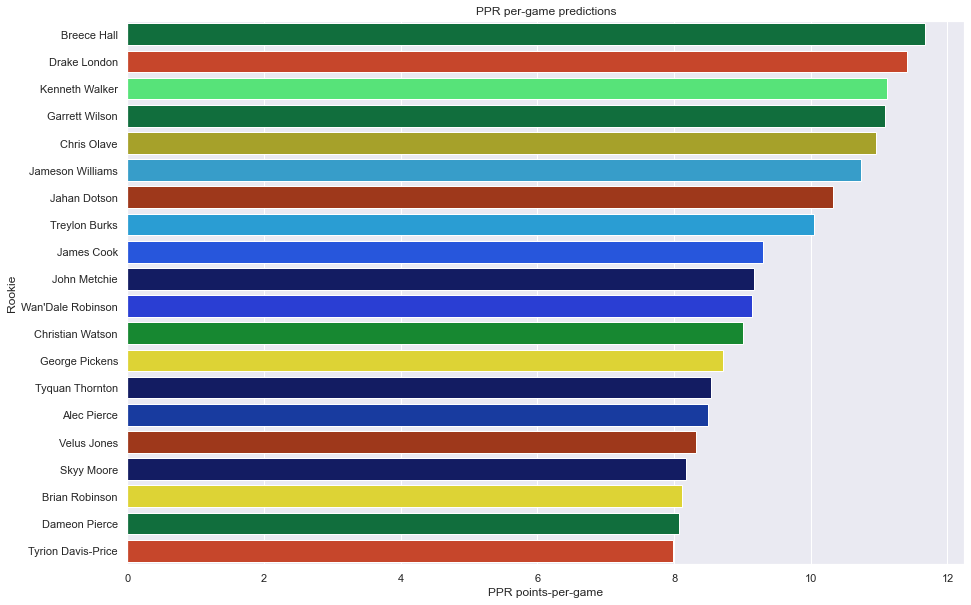

In [95]:
sns.set(rc={'figure.figsize':(15,10)})
team_palette = ["#027D3C", "#E03511", "#40FA6D", "#027D3C", "#BBB415", "#1EA7E2", "#B42C05",
                "#0EA7EF", "#0947FA", "#06126F", "#0E29EF", "#049B27", "#F9EC19", "#06126F",   
                "#0230B5", "#B42C05", "#06126F", "#F9EC19"]
rookie_plot = sns.barplot(x="PPR_preds", y="player", data=best_picks, palette=team_palette)
plt.xlabel("PPR points-per-game")
plt.ylabel("Rookie")
plt.title("PPR per-game predictions")
rookie_plot.figure.savefig("rookie_barplot.png");